In [16]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
### THE ITERATION PARAMETERs
#physical parameters
delta = 0.05 #interface width
gamma = delta/3 #interface energy
A = 3*gamma/delta
Lambda = jnp.sqrt(2)*delta/4
W = Lambda*jnp.sqrt(A)
c_uniform = 0.70 #the mean concentration

#numerical parameters
stepmax = 1000000 # max number of iterations
tol = 1e-8 # parameter used as stopping criterion
image_num = 50 # number of images along the string
h = 1e-5 # time-step (limited by the ODE step but independent of n1)
N = 1000 #num of nodes
c1, c2 = -1.0, 1.0 #metastable compositions

#meshigird
dr = 1/N
r = jnp.linspace(0, 1, N+1)
r_mid = (r[1:] + r[:-1]) / 2

In [17]:
import numpy as np

def laplace_NeumannBoundary(N):
    factor = np.ones(N-1)
    diag1 = np.concatenate([factor, np.array([0.])])
    diag2 = np.concatenate([np.array([0.]), factor])
    diag = - (diag1 + diag2)
    M = np.diag(diag)
    np.fill_diagonal(M[: -1, 1:], factor)  
    np.fill_diagonal(M[1:, : -1], factor) 
    L = jnp.array(M) * N**2
    return L.T

def gradient_NeumannBoundary(N):
    diag = jnp.zeros(N)
    diag1 = jnp.ones(N-1)
    M = np.diag(diag)
    np.fill_diagonal(M[: -1, 1:], diag1)  
    np.fill_diagonal(M[1:, : -1], -diag1) 
    M[0,0] = -1
    M[-1, -1] = 1
    D = jnp.array(M)*N/2
    return D.T
'''
def laplace_NeumannBoundary(N):
    diag = np.full(N, -2)
    M = np.diag(diag)
    np.fill_diagonal(M[: -1, 1:], jnp.ones(N-1))  
    np.fill_diagonal(M[1:, : -1], jnp.ones(N-1))
    M[0, 1] = 2
    M[-1, -2] = 2  
    L = jnp.array(M) * N**2
    return L.T

def gradient_NeumannBoundary(N):
    diag = jnp.zeros(N)
    diag1 = jnp.ones(N-1)
    M = np.diag(diag)
    np.fill_diagonal(M[: -1, 1:], diag1)  
    np.fill_diagonal(M[1:, : -1], -diag1) 
    M[0, 1] = 0
    M[-1, -2] = 0
    D = jnp.array(M)*N/2
    return D.T
'''

L = laplace_NeumannBoundary(N)
D = gradient_NeumannBoundary(N)


print(laplace_NeumannBoundary(5)/5**2)
print(gradient_NeumannBoundary(5)/5*2)

[[-1.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -1.]]
[[-1. -1.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  1.  0. -1.]
 [ 0.  0.  0.  1.  1.]]


initial interface: 0.15000000000000002
[0.7        0.69929796 0.70025918 0.69946531 0.70034694 0.69946122
 0.70026327 0.69928571 0.70000816 0.70069388 0.69958163 0.70018776
 0.70075714 0.6995102  0.7        0.70045306 0.70086939 0.6994449
 0.69978163 0.70008163 0.7003449  0.70057143 0.70076122 0.70091429
 0.69918367 0.69925714 0.69929388 0.69929388 0.69925714 0.69918367
 0.69907347 0.70081633 0.70063878 0.70042449 0.70017347 0.69988571
 0.69956122 0.6992     0.70073469 0.70030612 0.69984082 0.69933878
 0.70075714 0.70018776 0.69958163 0.70091429 0.70024082 0.69953061
 0.70077755 0.7       ]


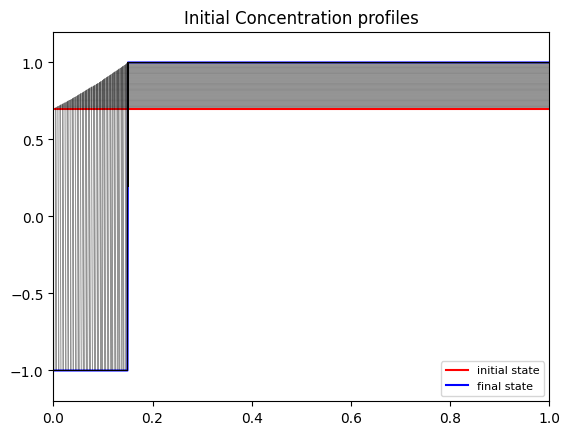

In [18]:
#the initial string
import matplotlib.pyplot as plt
def endpoints():
    ci = jnp.full(N, c_uniform)
    cf = jnp.full(N, c2)
    def interface(cf):
        r_f = (c_uniform - c2) / (c1 - c2) #because it's two dimensional case
        print(f"initial interface: {r_f}")
        for i in range(N):
            if r_mid[i] <= r_f:
                cf = cf.at[i].set(c1)
        return cf
    cf = interface(cf)
    return ci, cf

ci, cf = endpoints()

def initialize_linear(ci, cf):
    coef = jnp.linspace(0, 1, image_num)[:, jnp.newaxis]
    i = jnp.full((image_num, ), 1)[:, jnp.newaxis]
    return coef * (cf - ci) + i * ci

def generator(c_out):
    c = jnp.full(N, c_out)
    r_f = (c_uniform - c_out) / (c1 - c_out) #because it's two dimensional case
    for i in range(N):
        if r_mid[i] <= r_f:
            c = c.at[i].set(c1)
    return c

def initialize_growth():
    dc = (c2 - c_uniform) / (image_num - 1)
    c = []
    ci = jnp.full(N, c_uniform)
    c.append(ci)
    for i in range(image_num-1):
        c.append(generator(c_uniform + (i+1)*dc))
    return jnp.array(c)

c = initialize_growth()
#c = initialize_linear(ci, cf)
print(jnp.sum(c, axis=1)/N)

plt.figure(1)
plt.plot(r_mid, c[0, :], 'r', label="initial state")
plt.plot(r_mid, c[-1, :], 'b', label="final state")
for i in range(1, N-1):
    plt.plot(r_mid, c[i, :], 'k', linewidth='0.3')
plt.legend(fontsize=8)
plt.title("Initial Concentration profiles")
plt.xlim(0,1)
plt.ylim(-1.2, 1.2)
plt.show()

In [19]:
#EM & IMEX method
import jax

# the energy of each image
@jax.jit
def free_energy(c):
    F = A*((c**2 - 1)**2)/4 + jnp.power(W, 2)*jnp.power(jnp.dot(c,D), 2)/2
    return jnp.sum(F, axis=1)/N

#bulk_free_energy's gradient
@jax.jit
def bulk_free_energy_term(c):
    return A*(c**3 - c)

@jax.jit
def EM(c):
    return c + h * jnp.dot(-(W**2)*jnp.dot(c, L) + bulk_free_energy_term(c), L)

matrix1 = jnp.linalg.inv(jnp.eye(N) + h*(W**2)*jnp.dot(L, L))
@jax.jit
def IMEX(c):
    matrix2 = c + h * jnp.dot(bulk_free_energy_term(c), L)
    return jnp.dot(matrix2, matrix1)

In [20]:
# string method and main_loop

@jax.jit
def reparameterize(images):
    diff = images[1:, :] - images[:-1, :]
    dist = jnp.sum(diff**2, axis=1)
    #l = jnp.sqrt(jnp.concatenate((jnp.array([0.]), dist)))
    l = jnp.concatenate((jnp.array([0.]), jnp.sqrt(dist)))
    cumsum = jnp.cumsum(l) 
    cumsum = cumsum / cumsum[-1]

    @jax.jit
    def interplate(x, i):
        return jnp.interp(jnp.linspace(0, 1, image_num), cumsum, x[:, i])

    return jax.vmap(interplate, in_axes=(None, 0))(images, jnp.arange(N)).T

@jax.jit
def reparameterize_Eweighted(c):
    diff = c[1:, :] - c[:-1, :]
    dist = jnp.sqrt(jnp.sum(diff**2, axis=1))
    V = free_energy(c)
    V_mid = (V[1:] + V[:-1])/2

    @jax.jit
    def W(x):
        return x

    dl = jnp.concatenate((jnp.array([0.]), W(V_mid)*dist))
    l = jnp.cumsum(dl)
    l = l/l[-1]

    @jax.jit
    def interplate(x, i):
        return jnp.interp(jnp.linspace(0, 1, image_num), l, x[:, i])

    return jax.vmap(interplate, in_axes=(None, 0))(c, jnp.arange(N)).T

@jax.jit
def norm(images, images_old):
    err = images - images_old
    #norm_func = lambda x: jnp.linalg.norm(x)
    return jnp.sum(jax.vmap(jnp.linalg.norm, in_axes=0)(err)) / image_num

def main_loop_imex(images):
    for step in range(stepmax):
        images_old = images
        images = IMEX(images)
        images = reparameterize(images)
        err = norm(images, images_old)
        if step%10000 == 0: 
            print(f"{step} iteration, done, err = {err}")
        if err < tol: 
            print(f"number of iterations: {step}\n")
            break
    return images

def main_loop_em(images):
    for step in range(stepmax):
        images_old = images
        images = EM(images)
        images = reparameterize(images)
        err = norm(images, images_old)
        if step%50000 == 0: print(f"{step} iteration, done, err = {err}")
        if err < tol: 
            print(f"number of iterations: {step}\n")
            break
    return images

In [21]:
# the theoretical solution to the Cahn-Hilliard equation
r_mid = (r[1:] + r[:-1]) / 2
alpha = jnp.sqrt(2)/Lambda
M = (jnp.exp((1+c_uniform)*alpha/2) - 1) / (jnp.exp(alpha) - jnp.exp((1+c_uniform)*alpha/2))
c_theory = (M*jnp.exp(alpha*r_mid) - 1) / (M*jnp.exp(alpha*r_mid) + 1)

In [22]:
#iteration with line_profiler
from line_profiler import LineProfiler
from contextlib import redirect_stdout
import matplotlib.pyplot as plt

lp = LineProfiler()
func = lp(main_loop_imex)
c = func(c)
print(jnp.sum(c, axis=1)/N)

method = "IMEX"

with open(f"result-{method}/result-c_uniform-{c_uniform}/data-{c_uniform}", "w") as f1:
    with redirect_stdout(f1):
        print(f"delta : {delta}")
        print(f"gamma : {gamma}")
        print(f"tol : {tol}")
        print(f"h : {h}")

        F = free_energy(c)
        critical_index = jnp.argmax(F)
        barrier = F[critical_index] - F[0]
        print(f"Energy barrier: {barrier}")

        lp.print_stats()
#save the data

0 iteration, done, err = 2.9447032350108144
10000 iteration, done, err = 1.3470776150682866e-05
20000 iteration, done, err = 2.573404159198677e-06
30000 iteration, done, err = 1.2399020319608808e-06
40000 iteration, done, err = 6.157660816694228e-07
50000 iteration, done, err = 3.078966398755663e-07
60000 iteration, done, err = 1.546551435634828e-07
70000 iteration, done, err = 7.757840001247505e-08
80000 iteration, done, err = 3.880362978482656e-08
90000 iteration, done, err = 1.937515132934923e-08
number of iterations: 99524

[0.70000006 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365
 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365
 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365
 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365
 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365
 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365
 0.69986365 0.69986365 0.69986365 0.69986365 0.69986365 0.699863

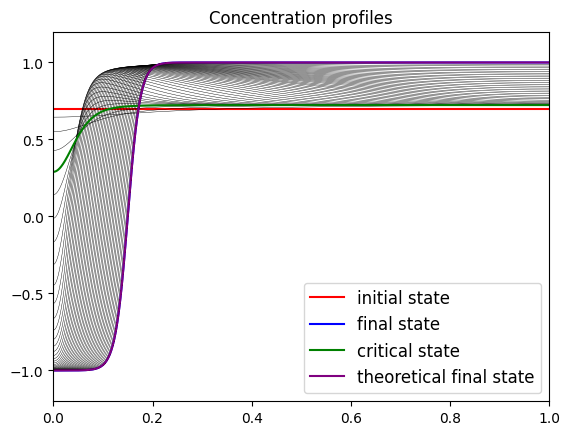

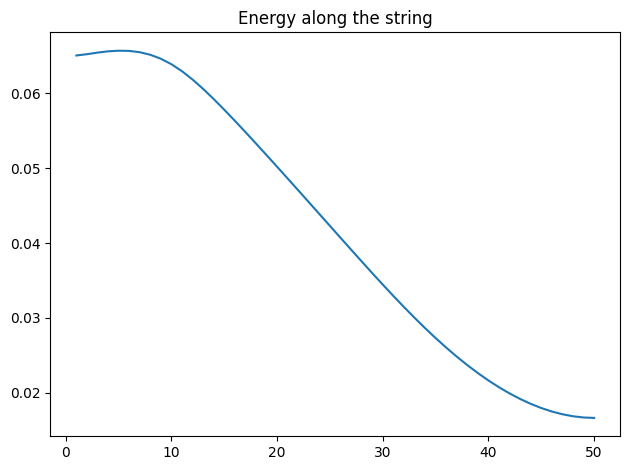

In [23]:
#draw the picture

def concentration_profile(show_evolution, issavefig):
    plt.figure(1)
    plt.plot(r_mid, c[0, :], 'r', label="initial state")
    plt.plot(r_mid, c[-1, :], 'b', label="final state")
    if show_evolution == True:
        for i in range(1, N-1):
            plt.plot(r_mid, c[i, :], 'k', linewidth='0.3')
    plt.plot(r_mid, c[critical_index, :], 'g', label="critical state")
    plt.plot(r_mid, c_theory, color='purple', label="theoretical final state")
    plt.legend(fontsize=12)
    plt.title("Concentration profiles")
    plt.axis([0,1,-0.25,1.25])
    plt.ylim(-1.2, 1.2)
    if issavefig == True:
        plt.savefig(f"result-{method}/result-c_uniform-{c_uniform}/concentration_profile_1D_{method}_{c_uniform}.png")
    plt.show()

def Energy_along_string(issavefig):
    plt.figure(2)
    plt.plot(jnp.arange(image_num)+1, F)
    plt.title('Energy along the string')
    plt.tight_layout()
    if issavefig == True:
        plt.savefig(f"result-{method}/result-c_uniform-{c_uniform}/Energy_along_string_1D_{method}_{c_uniform}.png")
    plt.show()

concentration_profile(show_evolution=True, issavefig=True)
Energy_along_string(issavefig=True)